# Predicting Individual Turnout in the 2020 General Election in Alamance County, North Carolina

#### This notebook uses voter registration and voter history data to predict turnout in the 2020 election for Alamance county in North Carolina. It includes data processing, feature engineering, modeling, and model evaluation. This code is not intended for use in production, and is a demonstration of skills.

[Overview of Alamance County's Government and Politics](https://en.wikipedia.org/wiki/Alamance_County,_North_Carolina#Government_and_politics)


In [3]:
# Import relevant packages
import os
import warnings
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Load data
current_dir = os.getcwd()

voter_registration_file = os.path.join(current_dir, "VR_Snapshot_20201103_Alamance.txt")
voter_history_file = os.path.join(current_dir, "ncvhis1.txt")

# Load voter registration and history files
# Specifically chose the snapshot of voter registration from the 2020 general election because people could update their registration since then.
#  Also using "recent registration" as predictive feature so want it to be as accurate of a snapshot as possible
# voter_registration = pd.read_csv(voter_registration_file, delimiter="\t", encoding="latin1")

#voter_registration = pd.DataFrame()

#chunking it out because we only care about Alamance County registrations for this election
#warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
#chunksize = 1000000  
#for chunk in pd.read_csv('~/Documents/murmuration_take_home/VR_Snapshot_20201103.txt', delimiter="\t", encoding="utf-16", chunksize=chunksize):
#    # Filter rows where county_desc is 'ALAMANCE'
#    filtered_chunk = chunk[chunk['county_desc'] == 'ALAMANCE']
#    # Append to the filtered data
#    voter_registration = pd.concat([voter_registration, filtered_chunk], ignore_index=True)
#voter_registration.to_csv('~/Documents/murmuration_take_home/VR_Snapshot_20201103_Alamance.csv')

voter_registration_file_updated = os.path.join(current_dir, "VR_Snapshot_20201103_Alamance.csv")

voter_registration = pd.read_csv(voter_registration_file_updated)

voter_history = pd.read_csv(voter_history_file, delimiter="\t", encoding="latin1")

# Get a general feel for size and shape of the data

print(f"Voter Registration Shape: {voter_registration.shape}")
print(f"Voter History Shape: {voter_history.shape}")
voter_registration.head()
voter_history.head()


/var/folders/9v/q1b50sfs0d574k8gq4znh3b40000gn/T/ipykernel_8600/970562824.py:37: DtypeWarning: Columns (26,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  voter_registration = pd.read_csv(voter_registration_file_updated)


Voter Registration Shape: (253040, 91)
Voter History Shape: (567490, 15)


,county_id,county_desc,voter_reg_num,election_lbl,election_desc,voting_method,voted_party_cd,voted_party_desc,pct_label,pct_description,ncid,voted_county_id,voted_county_desc,vtd_label,vtd_description
0,1,ALAMANCE,9050398,03/05/2024,03/05/2024 PRIMARY,EARLY VOTING IN-PERSON,REP,REPUBLICAN,07,ALBRIGHT,AA100000,1,ALAMANCE,07,07
1,1,ALAMANCE,9050398,11/03/2020,11/03/2020 GENERAL,ABSENTEE ONESTOP,UNA,UNAFFILIATED,07,ALBRIGHT,AA100000,1,ALAMANCE,07,07
2,1,ALAMANCE,9050398,11/08/2016,11/08/2016 GENERAL,ABSENTEE ONESTOP,UNA,UNAFFILIATED,07,ALBRIGHT,AA100000,1,ALAMANCE,07,07
3,1,ALAMANCE,9050398,03/03/2020,03/03/2020 PRIMARY,ELECTION DAY IN-PERSON,REP,REPUBLICAN,07,ALBRIGHT,AA100000,1,ALAMANCE,07,07
4,1,ALAMANCE,9050398,05/17/2022,05/17/2022 PRIMARY,ELECTION DAY IN-PERSON,REP,REPUBLICAN,07,ALBRIGHT,AA100000,1,ALAMANCE,07,07


In [4]:
# Filter history data to only include elections before (and including) 2020
voter_history['election_lbl'] = pd.to_datetime(voter_history['election_lbl'], errors='coerce')
voter_history = voter_history[voter_history['election_lbl'] <= '2020-11-03'].reset_index(drop=True)
voter_history['election_lbl'] = voter_history['election_lbl'].dt.strftime('%m/%d/%Y')

# Remove duplicates (mostly people who voted absentee and in person)
voter_history = voter_history.drop_duplicates(['voter_reg_num', 'election_lbl']).reset_index(drop=True)

## Feature Engineering

**For this model to work the best it can I need to isolate and feature engineer variables of interest. This includes:**
  - Age group
  - Race
  - Gender
  - Registered party
  - Previous voting history

**Other factors of importance to consider in later model iterations:**
  - Zip/other location features
  - Income
  - Ethnicity
  - Education
  - Attitudinal measures

**Knowledge of features was obtained using previous domain expertise and sources like Wikipedia, Bloomberg and Pew.**


In [5]:
# Feature engineering: General and Primary consistency scores
# I explored several measures to capture vote history, but ultimately I want to capture the behavior of people who just vote consistently general presidential and midterm elections, 
# those who vote consistently in primaries for those elections and generals. Voting history matters and will likely be one of the biggest predictors in the model.

voter_history['is_general'] = voter_history['election_lbl'].apply(
    lambda x: 1 if x in ['11/08/2016', '11/06/2018'] else 0)
voter_history['is_primary'] = voter_history['election_lbl'].apply(
    lambda x: 1 if x in ['03/03/2020', '03/15/2016', '05/08/2018'] else 0)

consistency_scores = voter_history.groupby('voter_reg_num').agg(
    general_consistency=('is_general', 'sum'),
    primary_consistency=('is_primary', 'sum')
).reset_index()

voter_history = voter_history.merge(consistency_scores, on='voter_reg_num', how='left')
voter_history[['general_consistency', 'primary_consistency']] = voter_history[['general_consistency', 'primary_consistency']].fillna(0)

# Create target variable
voter_history['voted_in_2020'] = voter_history['election_lbl'].apply(
    lambda x: 1 if x == '11/03/2020' else 0)

# Checking that I captured only the elections of interest. Municipal and state elections are 
# interesting and likely play a role but are out of scope for this iteration
print(pd.unique(voter_history.loc[voter_history.is_primary==1].election_desc))
print(pd.unique(voter_history.loc[voter_history.is_general==1].election_desc))


['03/03/2020 PRIMARY' '03/15/2016 PRIMARY' '05/08/2018 PRIMARY']
['11/08/2016 GENERAL' '11/06/2018 GENERAL']


In [6]:
#Data cleaning: reduce the voter_history dataframe to one record per person
vote_summary = voter_history.groupby('voter_reg_num').agg({
    'county_desc': 'first',          
    'county_id': 'first',  
    'ncid': 'first',                
    'general_consistency': 'max',          
    'primary_consistency': 'max',          
    'voted_in_2020': 'max',
}).reset_index()  # Reset index to make voter_reg_num a column

# Inspect the result
vote_summary

,voter_reg_num,county_desc,county_id,ncid,general_consistency,primary_consistency,voted_in_2020
0,4100,ALAMANCE,1,AA2052,2,2,1
1,4700,ALAMANCE,1,AA2055,2,3,1
2,6900,ALAMANCE,1,AA2062,2,2,1
3,8800,ALAMANCE,1,AA2073,1,1,1
4,9000,ALAMANCE,1,AA2079,2,1,1
...,...,...,...,...,...,...,...
102239,9243961,ALAMANCE,1,DD220682,0,0,1
102240,9243962,ALAMANCE,1,BY712379,0,0,1
102241,9243963,ALAMANCE,1,DE307662,1,0,1
102242,9243969,ALAMANCE,1,EH836963,2,1,1


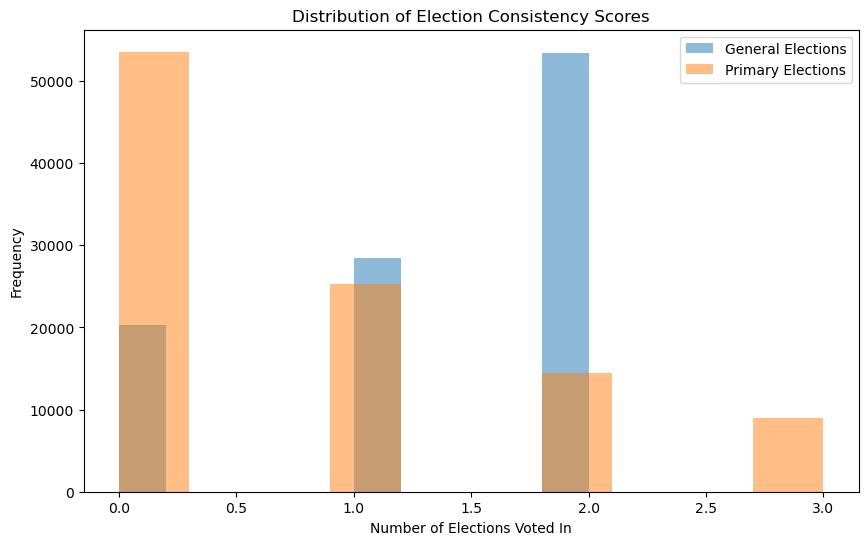

In [7]:
# Data Inspection: Plot histograms for general and primary consistency
plt.figure(figsize=(10, 6))
plt.hist(vote_summary['general_consistency'], bins=10, alpha=0.5, label='General Elections')
plt.hist(vote_summary['primary_consistency'], bins=10, alpha=0.5, label='Primary Elections')
plt.xlabel('Number of Elections Voted In')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Election Consistency Scores')
plt.show()

# This graph shows me that most people have voted in both of the recent main general elections and none of the primaries


In [8]:
# Feature Engineering: gender, race, party affiliation, and age
# race codes obtained from: https://s3.amazonaws.com/dl.ncsbe.gov/ENRS/layout_history_stats.txt
voter_registration['is_male'] = np.where(voter_registration['sex_code'] == 'M', 1, 0)

# One-hot encode the race column -- reference group is unidentified 
voter_registration['race_white'] = voter_registration['race_code'].apply(
    lambda x: 1 if x == 'W' else 0
)
voter_registration['race_black'] = voter_registration['race_code'].apply(
    lambda x: 1 if x == 'B' else 0
)
voter_registration['race_aapi'] = voter_registration['race_code'].apply(
    lambda x: 1 if x in ['A', 'I', 'P'] else 0
)

voter_registration['race_other'] = voter_registration['race_code'].apply(
    lambda x: 1 if x in ['O', 'M'] else 0
)

# One-hot encode party affiliation (as identified in voter registration in 2024) -- reference group here is unnafiliated or not labeled
voter_registration['reg_dem'] = voter_registration['party_cd'].apply(
    lambda x: 1 if x == 'DEM' else 0
)

voter_registration['reg_republican'] = voter_registration['party_cd'].apply(
    lambda x: 1 if x == 'REP' else 0
)

voter_registration['reg_other'] = voter_registration['party_cd'].apply(
    lambda x: 1 if x not in {'DEM', 'REP','UNA','NLB'} else 0
)

age_dummies = pd.get_dummies(voter_registration['age_group'],dtype = int)
#age_dummies = age_dummies.drop(columns=['Age < 18 Or Invalid Birth Dates','Age 18 - 25'])
#age_dummies

voter_registration = pd.concat([voter_registration, age_dummies], axis=1)


In [9]:
# Feature Engineering: Registration

# Extract the registration year -- i need a measure to include the behavior of people who never voted before but registered and voted in 2020 as they're likely to be more involved!

voter_registration['registr_dt'] = pd.to_datetime(voter_registration['registr_dt'], errors='coerce')
voter_registration['registration_year'] = voter_registration['registr_dt'].dt.year
#identify people who updated their registration after the last general election
voter_registration['new_or_updated_registrant'] = (voter_registration['registration_year'] > 2018).astype(int)


## Data Merging and Exploration

In [10]:
# Merge voter registration and history data

print(set(voter_registration.columns).intersection(set(voter_history.columns))
)
#keep only columns of interest
voter_registration = voter_registration[['county_id', 'county_desc', 'voter_reg_num', 'ncid', 'last_name',
       'first_name','voter_status_desc', 'voter_status_reason_desc','sex_code','is_male','race_code', 'race_white', 'race_black', 'race_aapi','race_other',
       'party_cd','reg_dem', 'reg_republican', 'reg_other', 'age_group','Age < 18 Or Invalid Birth Dates','Age 18 - 25','Age 26 - 40', 'Age 41 - 65','Age Over 66',
       'registration_year','new_or_updated_registrant']]


voter_data = pd.merge(voter_registration, vote_summary, on=['county_desc', 'county_id', 'ncid', 'voter_reg_num'], how="inner")

{'county_desc', 'ncid', 'county_id', 'voter_reg_num'}


In [11]:
# Examine turnout in 2020 by various cuts to get a feel for the data before I model 
print(f'2020 Voter Turnout : {voter_data.voted_in_2020.value_counts(normalize = True)}')

# Turn out in this dataset feels really inflated -- i looked into this but not sure why 


2020 Voter Turnout : voted_in_2020
1    0.862736
0    0.137264
Name: proportion, dtype: float64


In [12]:

print(voter_data.groupby('sex_code')['voted_in_2020'].mean()) #males and females voted in about equal rates

print(voter_data.groupby('age_group')['voted_in_2020'].mean()) #41-65 age group turned out in the highest numbers

print(voter_data.groupby('race_aapi')['voted_in_2020'].mean()) #asian american and white people voted more, but not by much
print(voter_data.groupby('race_white')['voted_in_2020'].mean())
print(voter_data.groupby('race_black')['voted_in_2020'].mean())
print(voter_data.groupby('race_other')['voted_in_2020'].mean())

print(voter_data.groupby(['new_or_updated_registrant'],observed=True)['voted_in_2020'].mean().sort_values( ascending=False)) #new/updated registered voters turned out more
print(voter_data.groupby(['primary_consistency','new_or_updated_registrant'],observed=True)['voted_in_2020'].mean().sort_values( ascending=False))


sex_code
F    0.862980
M    0.853971
U    0.910965
Name: voted_in_2020, dtype: float64
age_group
Age 18 - 25    0.842221
Age 26 - 40    0.844185
Age 41 - 65    0.909226
Age Over 66    0.812640
Name: voted_in_2020, dtype: float64
race_aapi
0    0.862613
1    0.875000
Name: voted_in_2020, dtype: float64
race_white
0    0.854635
1    0.866580
Name: voted_in_2020, dtype: float64
race_black
0    0.867485
1    0.842365
Name: voted_in_2020, dtype: float64
race_other
0    0.863475
1    0.836327
Name: voted_in_2020, dtype: float64
new_or_updated_registrant
1    0.972841
0    0.841325
Name: voted_in_2020, dtype: float64
primary_consistency  new_or_updated_registrant
3                    0                            0.987656
                     1                            0.984615
0                    1                            0.980896
2                    1                            0.971901
                     0                            0.957149
1                    1                  

## Modeling and Evaluation

In [13]:
# Our reference variables are:
# Race_unidentified
# Reg_unnafiliated or not labeled
# Age_18-25
features = voter_data[[
    'is_male', 'race_white', 'race_black', 'race_aapi', 'reg_dem', 'reg_republican', 
    'general_consistency', 'primary_consistency', 'new_or_updated_registrant', 'Age 26 - 40', 'Age 41 - 65',
       'Age Over 66'
]]
# Target variable
target = voter_data['voted_in_2020']

# Split into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Check the shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(73639, 12) (18410, 12) (73639,) (18410,)


Accuracy: 0.6876697447039652
ROC-AUC: 0.7681014364223809
              precision    recall  f1-score   support

           0       0.27      0.78      0.40      2497
           1       0.95      0.67      0.79     15913

    accuracy                           0.69     18410
   macro avg       0.61      0.73      0.60     18410
weighted avg       0.86      0.69      0.74     18410



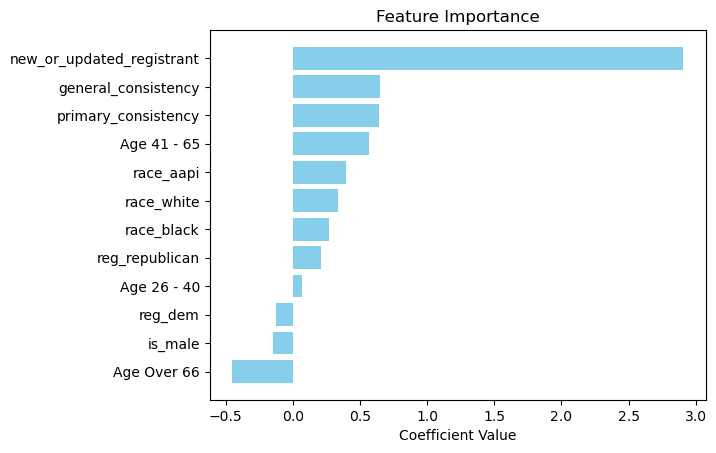

In [15]:
# Logistic regression model

# I chose this model because it's a simple solution
# Because the classes (0 and 1) don't occur at the same rates I weighted the classes for better performance
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred))

# Feature importance
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=True)

plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

In [ ]:
coefficients

## Analysis and Discussion

**Evaluation Metrics Interpretation:**
- The model predicts correctly whether someone voted in the 2020 election 69% of the time. This is a decent score, but alone doesn't provide enough insight given the class imbalance.
- The ROC-AUC metric helps us understand performance at all thresholds. Here the ROC-AUC score is 77%, which gives the model decent predictive power. 
- The model is not very precise at classifying those who didn't vote. That is, there are a decent amount of false positives. 
- However, the model correctly classifies 78% of those who did not vote.
- The model is very precise at classifying those who did vote. There are few false positives here.
- The model correctly classifies 68% of those who did vote.

**Feature Importance Interpretation:**
- New or recently updated registrations was the most important predictive feature. This is likely due to higher engagement and excitement.
- Voting consistently in general elections and primary elections were the next most important features. This also makes sense since consistent voters are more likely to vote again! 
- Being in the 41-65 age group was a moderately predictive feature relative to the 18-25 age group. While this initially surprised me, it aligns with expectations, as 41-65-year-olds are the largest age group in this dataset.
- Identifying as Asian, White, or Black was moderately predictive compared to unclassified race. This aligns with expectations and is consistent with the findings from exploratory analysis.
- Being a registered republican was a moderately predictive feature relative to being an unaffiliated voter. That does not not surprise me as Alamance county leans Republican.


## Limitations and Next Steps

**If I had more time I would:**
- Explore including other features, especially those related to income, education, and geography.
- Include interaction terms to better understand the relationship between existing features, like the interplay between age and recent registration or age and registered party.
- Evaluate other models including: 
    - Logistic Regression with regularization. This approach could address multicollinearity issues identified in the feature correlation analysis (see chart below). 
    - Ensemble-based models like Random Forest. These models may handle categorical variables more effectively and capture complex, non-linear relationships in the data.
- Develop a clearer narrative around how insights from the model could inform voter outreach strategies or resource allocation. For instance, targeting new registrants or consistent voters differently.

**If a partner wanted to use this model to predict turnout for an upcoming election I would**
- Reccomend using data that is localized to their specific region.
- Engage with them to better understand their goals, ensuring the insights align with their outreach and resource strategies.
- Highlight the importance of updating the data to reflect recent registration changes or turnout patterns, ensuring the model's predictions remain relevant.







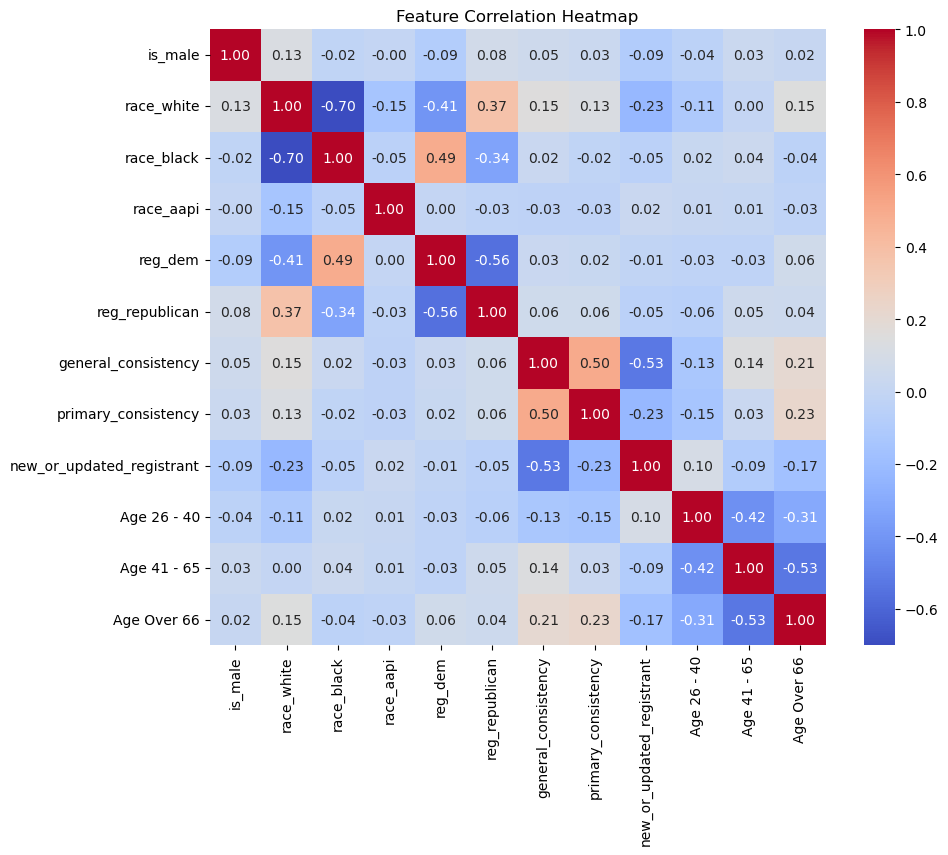

In [16]:
# Running out correlations of the features of interest show that some features are pretty correlated (democrat versus repub, primary and general consistency, etc)
correlation_matrix = features.corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,              # Show correlation values
    fmt=".2f",               # Format numbers to 2 decimal places
    cmap="coolwarm",         # Use a diverging colormap
    cbar=True,               # Show the color bar
    square=True              # Make the cells square-shaped
)

# Add title
plt.title("Feature Correlation Heatmap")

# Show the plot
plt.show()
